In [2]:
import json
from windows_tools.installed_software import get_installed_software
import requests
import time

# Lista para almacenar los detalles de software instalado
software_details = []

# Ruta del archivo de bloc de notas para guardar los resultados
archivo_resultados = "resultados_software_vulnerabilidades.txt"

# Obtener la lista de software instalado en Windows
for software in get_installed_software():
    software_details.append({"name": software['name'], "version": software['version'], "publisher": software['publisher']})

# Función para buscar vulnerabilidades asociadas a un software específico en VulDB
def buscar_vulnerabilidades(nombre_software):
    url = "https://vuldb.com/?api"

    # Parámetros de la solicitud
    datos = {
        "apikey": '33d6f703126b8727526d02ce9d249789',  # Reemplaza 'TU_API_KEY' con tu API key de VulDB
        "search": nombre_software
    }

    try:  
        print(f"Búsqueda de vulnerabilidades para: {nombre_software}")
        # Realizar solicitud POST a VulDB
        respuesta = requests.post(url, data=datos)
        # Convertir la respuesta a JSON
        objeto = respuesta.json()
        # Verificar si la clave 'result' está presente en el objeto
        if 'result' in objeto:
            # Mostrar las primeras tres vulnerabilidades encontradas
            vulnerabilidades = [item['vulnerability'] for item in objeto['result'][:3]]
            return vulnerabilidades
        else:
            print("No se encontraron vulnerabilidades.")
            return []
    except requests.exceptions.RequestException as e:
        print(f'Error en la solicitud: {e}')
        return []

# Esperar un poco para evitar exceder los límites de solicitud
time.sleep(2)

# Mostrar los detalles de software en formato JSON con las tres primeras vulnerabilidades debajo de la descripción
print("Detalles del software instalado:")
for software in software_details:
    vulnerabilidades = buscar_vulnerabilidades(software['name'])
    software['vulnerabilidades'] = vulnerabilidades
    print(json.dumps(software, indent=4))

    # Guardar los resultados en el archivo de bloc de notas
    with open(archivo_resultados, 'a') as file:
        file.write(json.dumps(software, indent=4) + "\n")


Detalles del software instalado:
Búsqueda de vulnerabilidades para: StarUML 6.0.1
No se encontraron vulnerabilidades.
{
    "name": "StarUML 6.0.1",
    "version": "6.0.1",
    "publisher": "MKLabs Co.,Ltd.",
    "vulnerabilidades": []
}
Búsqueda de vulnerabilidades para: Cisco Packet Tracer 7.3.1 64Bit
No se encontraron vulnerabilidades.
{
    "name": "Cisco Packet Tracer 7.3.1 64Bit",
    "version": "",
    "publisher": "Cisco Systems, Inc.",
    "vulnerabilidades": []
}
Búsqueda de vulnerabilidades para: GDR 1105 para SQL Server 2022 (KB5029379) (64-bit)
No se encontraron vulnerabilidades.
{
    "name": "GDR 1105 para SQL Server 2022 (KB5029379) (64-bit)",
    "version": "16.0.1105.1",
    "publisher": "Microsoft Corporation",
    "vulnerabilidades": []
}
Búsqueda de vulnerabilidades para: GDR 1110 para SQL Server 2022 (KB5032968) (64-bit)
No se encontraron vulnerabilidades.
{
    "name": "GDR 1110 para SQL Server 2022 (KB5032968) (64-bit)",
    "version": "16.0.1110.1",
    "publis

Programa: StarUML 6.0.1, Vulnerabilidades: 0
Programa: Cisco Packet Tracer 7.3.1 64Bit, Vulnerabilidades: 0
Programa: GDR 1105 para SQL Server 2022 (KB5029379) (64-bit), Vulnerabilidades: 0
Programa: GDR 1110 para SQL Server 2022 (KB5032968) (64-bit), Vulnerabilidades: 0
Programa: Microsoft Azure Compute Emulator - v2.9.7, Vulnerabilidades: 0
Programa: Microsoft SQL Server 2022 (64-bit), Vulnerabilidades: 3
Programa: Microsoft SQL Server 2022 (64-bit), Vulnerabilidades: 3
Programa: Mozilla Firefox (x64 es-ES), Vulnerabilidades: 3
Programa: Mozilla Maintenance Service, Vulnerabilidades: 3
Programa: MPLAB XC8 C Compiler, Vulnerabilidades: 0
Programa: , Vulnerabilidades: 3
Programa: , Vulnerabilidades: 3
Programa: Apache NetBeans IDE 12.5, Vulnerabilidades: 0
Programa: Notepad++ (64-bit x64), Vulnerabilidades: 3
Programa: Tracker, Vulnerabilidades: 3
Programa: Microsoft Office Profesional Plus 2019 - es-es, Vulnerabilidades: 0
Programa: , Vulnerabilidades: 3
Programa: WinRAR 6.00 (64-bit)

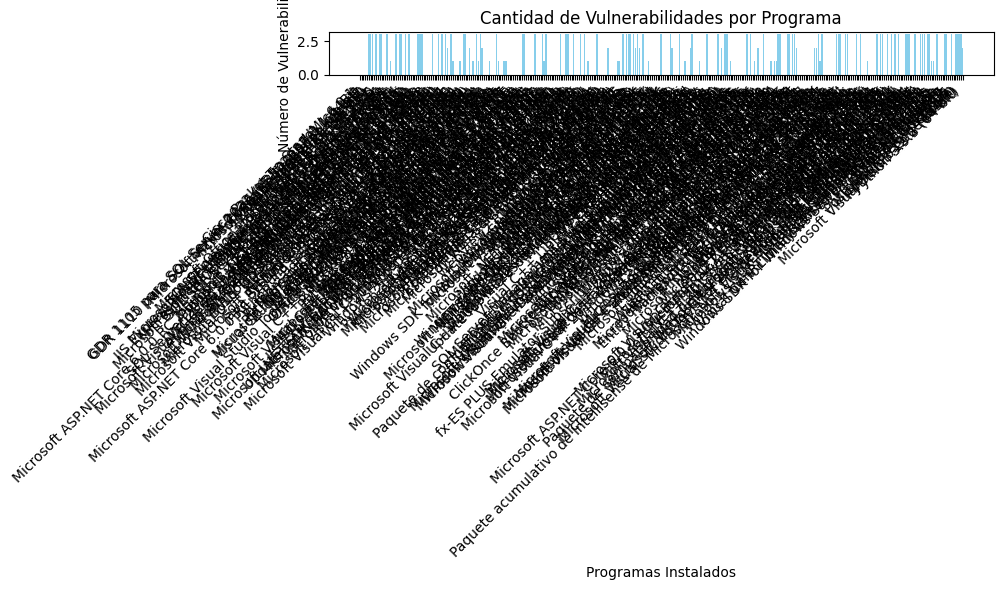

In [1]:
import os
import json
import requests
from azure.cosmos import CosmosClient, PartitionKey, exceptions
from datetime import datetime as dt
from windows_tools.installed_software import get_installed_software
import matplotlib.pyplot as plt

# Configuración de variables
settings = {
    'host': os.environ.get('ACCOUNT_HOST', 'https://andresdia02.documents.azure.com:443/'),
    'master_key': os.environ.get('ACCOUNT_KEY', 'ovpWKq3QnVf76g2KKnwQb2FArJz9X6lroZ3bqhvqXIkdE3rgxObPWRVWxNU6yWEwDxER5Imd983HACDbCIbnUQ=='),
    'database_id': os.environ.get('COSMOS_DATABASE', 'base1'),
    'container_id': os.environ.get('COSMOS_CONTAINER', 'container2')
}

HOST = settings['host']
MASTER_KEY = settings['master_key']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']

def create_cosmos_client():
    return CosmosClient(HOST, {'masterKey': MASTER_KEY}, user_agent="CosmosDBPythonQuickstart", user_agent_overwrite=True)

def create_database(client):
    try:
        return client.create_database(id=DATABASE_ID)
    except exceptions.CosmosResourceExistsError:
        return client.get_database_client(DATABASE_ID)

def create_container(db_client):
    try:
        return db_client.create_container(id=CONTAINER_ID, partition_key=PartitionKey(path='/partitionKey'))
    except exceptions.CosmosResourceExistsError:
        return db_client.get_container_client(CONTAINER_ID)

def search_vulnerabilities(software, max_vulnerabilities=3):
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": max_vulnerabilities
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            return response.json()
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return None

def get_cve_details(cve):
    url = f'https://cve.circl.lu/api/cve/{cve}'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
    except Exception as e:
        print(f"Error al obtener detalles de CVE {cve}: {e}")
    return None

def format_sec_data(unique_id, json_data):
    unique_suffix = dt.now().strftime('%Y%m%d%H%M%S%f')
    sec_data = {
        'id': f"{unique_id}_{unique_suffix}",
        'partitionKey': 'Account1',
        'date': dt.now().strftime('%Y-%m-%d %H:%M:%S'),
        'vulnerability': json_data,
        'Description': json_data
    }
    return sec_data

def plot_vulnerabilities(installed_programs, vulnerabilities_counts):
    plt.figure(figsize=(10, 6))
    plt.bar(installed_programs, vulnerabilities_counts, color='skyblue')
    plt.xlabel('Programas Instalados')
    plt.ylabel('Número de Vulnerabilidades')
    plt.title('Cantidad de Vulnerabilidades por Programa')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def main():
    client = create_cosmos_client()
    db = create_database(client)
    container = create_container(db)

    installed_programs = [program['name'] for program in get_installed_software()]
    vulnerabilities_counts = []

    for program in installed_programs:
        vulnerabilities = search_vulnerabilities(program)
        if vulnerabilities and 'data' in vulnerabilities:
            vulnerabilities_counts.append(len(vulnerabilities['data']['search']))
        else:
            vulnerabilities_counts.append(0)

    for program, count in zip(installed_programs, vulnerabilities_counts):
        print(f"Programa: {program}, Vulnerabilidades: {count}")

    plot_vulnerabilities(installed_programs, vulnerabilities_counts)

if __name__ == "__main__":
    main()


StarUML 6.0.1: 0 vulnerabilidades
Cisco Packet Tracer 7.3.1 64Bit: 0 vulnerabilidades
GDR 1105 para SQL Server 2022 (KB5029379) (64-bit): 0 vulnerabilidades
GDR 1110 para SQL Server 2022 (KB5032968) (64-bit): 0 vulnerabilidades
Microsoft Azure Compute Emulator - v2.9.7: 0 vulnerabilidades
Microsoft SQL Server 2022 (64-bit): 3 vulnerabilidades
Microsoft SQL Server 2022 (64-bit): 3 vulnerabilidades
Mozilla Firefox (x64 es-ES): 3 vulnerabilidades
Mozilla Maintenance Service: 3 vulnerabilidades
MPLAB XC8 C Compiler: 0 vulnerabilidades
Total de vulnerabilidades encontradas: 12
Total de vulnerabilidades de severidad alta: 2
Total de vulnerabilidades de severidad media: 2
Total de vulnerabilidades de severidad baja: 0


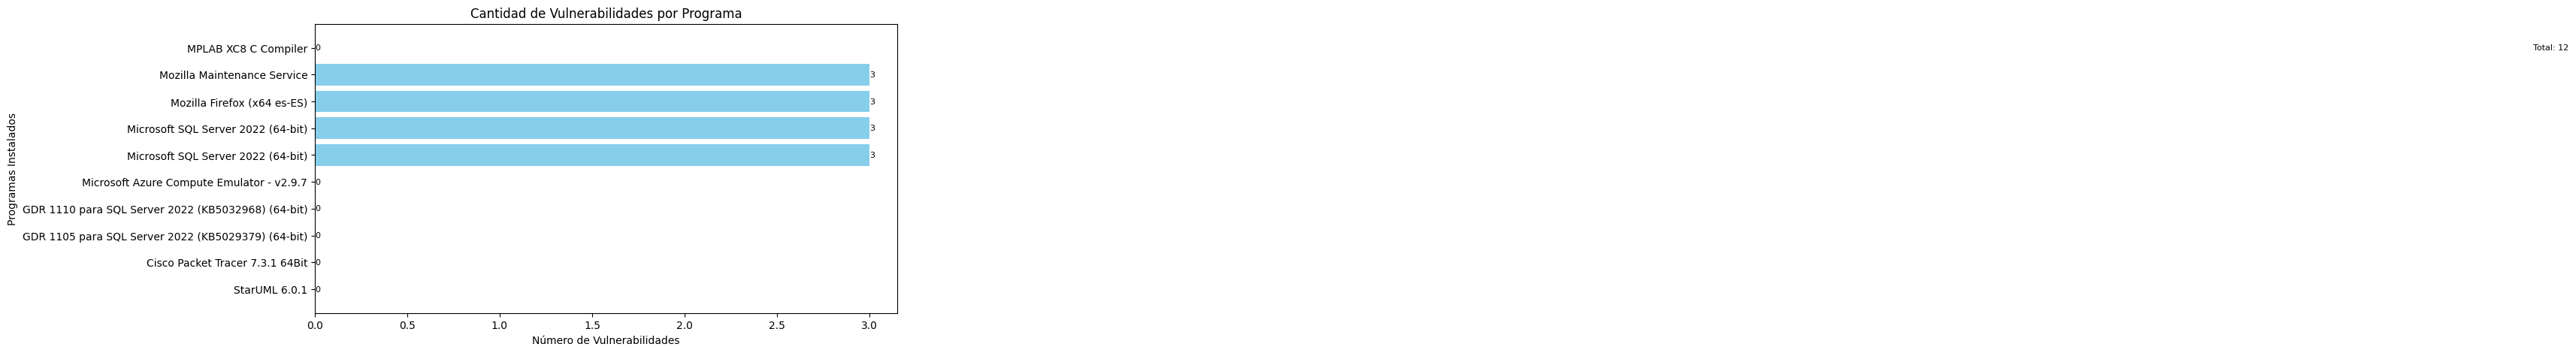

In [13]:
import os
import json
import requests
from azure.cosmos import CosmosClient, PartitionKey, exceptions
from datetime import datetime as dt
from windows_tools.installed_software import get_installed_software
import matplotlib.pyplot as plt

# Configuración de variables
settings = {
    'host': os.environ.get('ACCOUNT_HOST', 'https://andresdia02.documents.azure.com:443/'),
    'master_key': os.environ.get('ACCOUNT_KEY', 'ovpWKq3QnVf76g2KKnwQb2FArJz9X6lroZ3bqhvqXIkdE3rgxObPWRVWxNU6yWEwDxER5Imd983HACDbCIbnUQ=='),
    'database_id': os.environ.get('COSMOS_DATABASE', 'base1'),
    'container_id': os.environ.get('COSMOS_CONTAINER', 'container2')
}

HOST = settings['host']
MASTER_KEY = settings['master_key']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']

MAX_PROGRAMS = 10  # Límite máximo de programas a mostrar
MAX_VULNERABILITIES_PER_PROGRAM = 5  # Límite máximo de vulnerabilidades por programa a mostrar

def create_cosmos_client():
    return CosmosClient(HOST, {'masterKey': MASTER_KEY}, user_agent="CosmosDBPythonQuickstart", user_agent_overwrite=True)

def create_database(client):
    try:
        return client.create_database(id=DATABASE_ID)
    except exceptions.CosmosResourceExistsError:
        return client.get_database_client(DATABASE_ID)

def create_container(db_client):
    try:
        return db_client.create_container(id=CONTAINER_ID, partition_key=PartitionKey(path='/partitionKey'))
    except exceptions.CosmosResourceExistsError:
        return db_client.get_container_client(CONTAINER_ID)

def search_vulnerabilities(software, max_vulnerabilities=3):
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": max_vulnerabilities
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            return response.json().get('data', {}).get('search', [])
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return []

def main():
    client = create_cosmos_client()
    db = create_database(client)
    container = create_container(db)

    installed_programs = [program['name'] for program in get_installed_software()][:MAX_PROGRAMS]
    vulnerabilities_counts = []
    high_vulnerabilities = 0
    medium_vulnerabilities = 0
    low_vulnerabilities = 0

    for program in installed_programs:
        vulnerabilities = search_vulnerabilities(program)
        vulnerabilities = vulnerabilities[:MAX_VULNERABILITIES_PER_PROGRAM]
        vulnerability_count = len(vulnerabilities)
        vulnerabilities_counts.append(vulnerability_count)

        # Contar las vulnerabilidades por severidad
        for vulnerability in vulnerabilities:
            cvss_score = vulnerability.get('_source', {}).get('cvss', {}).get('score', None)
            if cvss_score:
                if cvss_score >= 7.0:
                    high_vulnerabilities += 1
                elif 4.0 <= cvss_score < 7.0:
                    medium_vulnerabilities += 1
                else:
                    low_vulnerabilities += 1

        print(f"{program}: {vulnerability_count} vulnerabilidades")

    total_vulnerabilities = sum(vulnerabilities_counts)
    print(f"Total de vulnerabilidades encontradas: {total_vulnerabilities}")
    print(f"Total de vulnerabilidades de severidad alta: {high_vulnerabilities}")
    print(f"Total de vulnerabilidades de severidad media: {medium_vulnerabilities}")
    print(f"Total de vulnerabilidades de severidad baja: {low_vulnerabilities}")

    plot_vulnerabilities(installed_programs, vulnerabilities_counts, total_vulnerabilities)

def plot_vulnerabilities(installed_programs, vulnerabilities_counts, total_vulnerabilities):
    plt.figure(figsize=(10, min(len(installed_programs) * 0.5, 6)))
    plt.barh(range(len(installed_programs)), vulnerabilities_counts, color='skyblue')
    plt.xlabel('Número de Vulnerabilidades')
    plt.ylabel('Programas Instalados')
    plt.title('Cantidad de Vulnerabilidades por Programa')
    plt.yticks(range(len(installed_programs)), installed_programs)
    for i, count in enumerate(vulnerabilities_counts):
        plt.text(count, i, str(count), ha='left', va='center', fontsize=8)
    plt.text(total_vulnerabilities, len(installed_programs) - 1, f'Total: {total_vulnerabilities}', ha='left', va='center', fontsize=8)
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import os
import json
import requests
from azure.cosmos import CosmosClient, PartitionKey, exceptions
from datetime import datetime as dt
from windows_tools.installed_software import get_installed_software
import matplotlib.pyplot as plt

# Configuración de variables
settings = {
    'host': os.environ.get('ACCOUNT_HOST', 'https://andresdia02.documents.azure.com:443/'),
    'master_key': os.environ.get('ACCOUNT_KEY', 'ovpWKq3QnVf76g2KKnwQb2FArJz9X6lroZ3bqhvqXIkdE3rgxObPWRVWxNU6yWEwDxER5Imd983HACDbCIbnUQ=='),
    'database_id': os.environ.get('COSMOS_DATABASE', 'base1'),
    'container_id': os.environ.get('COSMOS_CONTAINER', 'container2')
}

HOST = settings['host']
MASTER_KEY = settings['master_key']
DATABASE_ID = settings['database_id']
CONTAINER_ID = settings['container_id']

MAX_PROGRAMS = 10  # Límite máximo de programas a mostrar
MAX_VULNERABILITIES_PER_PROGRAM = 5  # Límite máximo de vulnerabilidades por programa a mostrar

def create_cosmos_client():
    return CosmosClient(HOST, {'masterKey': MASTER_KEY}, user_agent="CosmosDBPythonQuickstart", user_agent_overwrite=True)

def create_database(client):
    try:
        return client.create_database(id=DATABASE_ID)
    except exceptions.CosmosResourceExistsError:
        return client.get_database_client(DATABASE_ID)

def create_container(db_client):
    try:
        return db_client.create_container(id=CONTAINER_ID, partition_key=PartitionKey(path='/partitionKey'))
    except exceptions.CosmosResourceExistsError:
        return db_client.get_container_client(CONTAINER_ID)

def search_vulnerabilities(software):
    url = "https://vulners.com/api/v3/search/lucene/"
    headers = {"Content-Type": "application/json"}
    data = {
        "query": software,
        "size": MAX_VULNERABILITIES_PER_PROGRAM
    }
    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            return response.json().get('data', {}).get('search', [])
    except Exception as e:
        print(f"Error al buscar vulnerabilidades para {software}: {e}")
    return []

def main():
    client = create_cosmos_client()
    db = create_database(client)
    container = create_container(db)

    installed_programs = get_installed_software()[:MAX_PROGRAMS]
    vulnerabilities_counts = []
    high_vulnerabilities = 0
    medium_vulnerabilities = 0
    low_vulnerabilities = 0

    for program in installed_programs:
        vulnerabilities = search_vulnerabilities(program['name'])

        # Contar las vulnerabilidades por severidad
        for vulnerability in vulnerabilities:
            cvss_score = vulnerability.get('_source', {}).get('cvss', {}).get('score', None)
            if cvss_score:
                if cvss_score >= 7.0:
                    high_vulnerabilities += 1
                elif 4.0 <= cvss_score < 7.0:
                    medium_vulnerabilities += 1
                else:
                    low_vulnerabilities += 1

        vulnerability_count = len(vulnerabilities)
        vulnerabilities_counts.append(vulnerability_count)

        # Mostrar detalles de las vulnerabilidades
        print(f"{program['name']}: {vulnerability_count} vulnerabilidades")
        for vulnerability in vulnerabilities:
            cve = vulnerability['_source'].get('cve', 'Desconocido')
            cvss = vulnerability['_source'].get('cvss', {}).get('score', 'Desconocido')
            print(f"- CVE: {cve}, CVSS: {cvss}")

    total_vulnerabilities = sum(vulnerabilities_counts)
    print(f"\nTotal de vulnerabilidades encontradas: {total_vulnerabilities}")
    print(f"Total de vulnerabilidades de severidad alta: {high_vulnerabilities}")
    print(f"Total de vulnerabilidades de severidad media: {medium_vulnerabilities}")
    print(f"Total de vulnerabilidades de severidad baja: {low_vulnerabilities}")

    plot_vulnerabilities(vulnerabilities_counts, total_vulnerabilities, high_vulnerabilities, medium_vulnerabilities, low_vulnerabilities)

def plot_vulnerabilities(vulnerabilities_counts, total_vulnerabilities, high_vulnerabilities, medium_vulnerabilities, low_vulnerabilities):
    plt.figure(figsize=(8, 6))
    labels = ['Alta', 'Media', 'Baja']
    counts = [high_vulnerabilities, medium_vulnerabilities, low_vulnerabilities]
    plt.bar(labels, counts, color=['red', 'orange', 'green'])
    plt.xlabel('Severidad')
    plt.ylabel('Total de Vulnerabilidades')
    plt.title('Distribución de Vulnerabilidades por Severidad')
    for i, count in enumerate(counts):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)
    plt.text(len(labels) - 1, total_vulnerabilities + 0.5, f'Total: {total_vulnerabilities}', ha='center', va='bottom', fontsize=8)
    plt.show()

if __name__ == "__main__":
    main()


StarUML 6.0.1: 0 vulnerabilidades
Cisco Packet Tracer 7.3.1 64Bit: 0 vulnerabilidades
GDR 1105 para SQL Server 2022 (KB5029379) (64-bit): 0 vulnerabilidades
GDR 1110 para SQL Server 2022 (KB5032968) (64-bit): 0 vulnerabilidades
Microsoft Azure Compute Emulator - v2.9.7: 0 vulnerabilidades
Microsoft SQL Server 2022 (64-bit): 5 vulnerabilidades
- CVE: Desconocido, CVSS: 0.0
- CVE: Desconocido, CVSS: 9.3
- CVE: Desconocido, CVSS: 5.8
- CVE: Desconocido, CVSS: 5.8
- CVE: Desconocido, CVSS: 0.0
Microsoft SQL Server 2022 (64-bit): 5 vulnerabilidades
- CVE: Desconocido, CVSS: 0.0
- CVE: Desconocido, CVSS: 9.3
- CVE: Desconocido, CVSS: 5.8
- CVE: Desconocido, CVSS: 5.8
- CVE: Desconocido, CVSS: 0.0
